# WarwickLanc SEIR Model First Example

In this notebook we present how to use the `warwickmodel` module to set up an instantiation of the model built by Universities of Warwick and Lancaster, using some toy data.

*The Warwick model is built by Universities of Warwick and Lancaster.*

In [1]:
# Load necessary libraries
import numpy as np
import epimodels as em
import warwickmodel as wm
import matplotlib
from scipy.stats import gamma
import plotly.graph_objects as go
from matplotlib import pyplot as plt
from iteration_utilities import deepflatten

## Model Setup
### Define setup matrices for the WarwickLanc Model

In [2]:
# Populate the model
regions = ['UK', 'FR']
age_groups = ['0-10', '10-25']

# Initial state of the system
region_data_matrix_0 = np.array([[1, 10], [1, 6]])
region_data_matrix_1 = np.array([[0.5, 3], [0.3, 3]])

regional_0 = em.RegionMatrix(
    regions[0], age_groups, region_data_matrix_0)
regional_1 = em.RegionMatrix(
    regions[1], age_groups, region_data_matrix_1)

contacts = em.ContactMatrix(age_groups, np.ones((len(age_groups), len(age_groups))))
matrices_contact = [contacts]

# Matrices contact
time_changes_contact = [1]
time_changes_region = [1]

matrices_region = [[regional_0, regional_1]]

### Set the parameters and initial conditions of the model and bundle everything together

In [3]:
# Instantiate model
model = wm.WarwickLancSEIRModel()

# Set the region names, contact and regional data of the model
model.set_regions(regions)
model.set_age_groups(age_groups)
model.read_contact_data(matrices_contact, time_changes_contact)
model.read_regional_data(matrices_region, time_changes_region)

times=np.arange(1, 20, 1).tolist()

# Set regional and time dependent parameters
regional_parameters = wm.RegParameters(
    model=model,
    region_index=1
)

# Set ICs parameters
ICs_parameters = wm.ICs(
    model=model,
    susceptibles_IC=[[500, 600] + [0, 0] * 5, [700, 800] + [0, 0] * 5],
    exposed1_IC=[[0, 0] * 6, [0, 0] * 6],
    exposed2_IC=[[0, 0] * 6, [0, 0] * 6],
    exposed3_IC=[[0, 0] * 6, [0, 0] * 6],
    exposed4_IC=[[0, 0] * 6, [0, 0] * 6],
    exposed5_IC=[[0, 0] * 6, [0, 0] * 6],
    infectives_sym_IC=[[10, 20] * 5 + [0, 0], [0, 5] * 5 + [0, 0]],
    infectives_asym_IC=[[15, 10] * 5 + [0, 0], [30, 10] * 5 + [0, 0]],
    recovered_IC= [[0, 0], [0, 0]]
)

# Set disease-specific parameters
disease_parameters = wm.DiseaseParameters(
    model=model,
    d=0.4 * np.ones(len(age_groups)),
    tau=0.4,
    we=[0.02, 0],
    omega=1
)

# Set transmission parameters
transmission_parameters = wm.Transmission(
    model=model,
    beta=0.5 * np.ones(len(age_groups)),
    alpha=0.5,
    gamma=1 * np.ones(len(age_groups))
)

# Set other simulation parameters
simulation_parameters = wm.SimParameters(
    model=model,
    method='RK45',
    times=times,
    eps=False
)

# Set vaccination parameters
vaccine_parameters = wm.VaccineParameters(
    model=model,
    vac=3,
    vacb=0.5,
    nu_tra=[1] * 6,
    nu_symp=[1] * 6,
    nu_inf=[1] * 6,
    nu_sev_h=[1] * 6,
    nu_sev_d=[1] * 6
)

# Set social distancing parameters
soc_dist_parameters = wm.SocDistParameters(
    model=model,
    phi=1
)

# Set all parameters in the controller
parameters = wm.ParametersController(
    model=model,
    regional_parameters=regional_parameters,
    ICs_parameters=ICs_parameters,
    disease_parameters=disease_parameters,
    transmission_parameters=transmission_parameters,
    simulation_parameters=simulation_parameters,
    vaccine_parameters=vaccine_parameters,
    soc_dist_parameters=soc_dist_parameters
)

### Simulate for the regions

In [4]:
# Simulate for all the regions
outputs = []

for r, reg in enumerate(regions):
    # List of initial conditions and parameters that characterise the model
    parameters.regional_parameters.region_index = r + 1

    # Simulate using the ODE solver
    outputs.append(model.simulate(parameters))

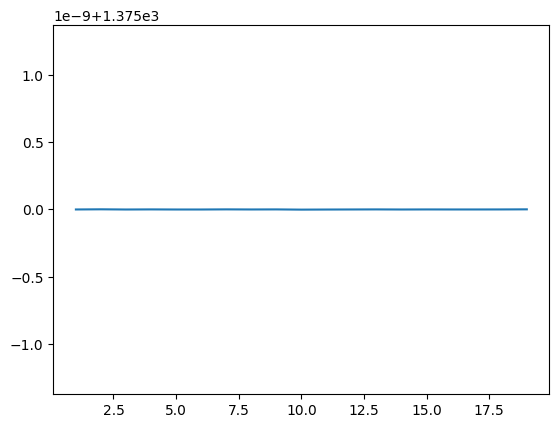

In [13]:
plt.plot(times, np.sum(outputs[0][:, :-len(age_groups)], axis=1))

## Plot the comparments of the two methods against each other
### Setup ``plotly`` and default settings for plotting

In [6]:
from plotly.subplots import make_subplots

colours = ['blue', 'red', 'green', 'purple', 'orange', 'black', 'gray', 'pink']

### Plot the comparments of the two regions against each other

In [7]:
# Trace names - represent the solver used for the simulation
trace_name = ['region {}'.format(r) for r in regions]

# Compartment list - type and age
comparments = []
for n in model.output_names():
    comparments.append('{}'.format(n))

# Plot for each comparment
for c, comparment in enumerate(comparments):
    fig = go.Figure()
    fig = make_subplots(rows=int(np.ceil(len(age_groups)/2)), cols=2, subplot_titles=tuple('ages {}'.format(a) for a in age_groups))
    # Plot (line plot for each solver method for each age)
    for a, age in enumerate(age_groups):
        if a != 0:
            for o, out in enumerate(outputs):
                fig.add_trace(
                    go.Scatter(
                        y=out[:, c*len(age_groups)+a],
                        x=parameters.simulation_parameters.times,
                        mode='lines',
                        name=trace_name[o],
                        line_color=colours[o],
                        showlegend=False
                    ),
                    row= int(np.floor(a / 2)) + 1,
                    col= a % 2 + 1
                )
        
        else:
            for o, out in enumerate(outputs):
                fig.add_trace(
                    go.Scatter(
                        y=out[:, c*len(age_groups)+a],
                        x=parameters.simulation_parameters.times,
                        mode='lines',
                        name=trace_name[o],
                        line_color=colours[o]
                    ),
                    row= int(np.floor(a / 2)) + 1,
                    col= a % 2 + 1
                )

    # Add axis labels
    fig.update_layout(
        boxmode='group',
        title=comparment, 
        width=800,
        plot_bgcolor='white',
        xaxis=dict(linecolor='black'),
        yaxis=dict(linecolor='black'),
        xaxis2=dict(linecolor='black'),
        yaxis2=dict(linecolor='black'),
        xaxis3=dict(linecolor='black'),
        yaxis3=dict(linecolor='black'),
        xaxis4=dict(linecolor='black'),
        yaxis4=dict(linecolor='black'),
        xaxis5=dict(linecolor='black'),
        yaxis5=dict(linecolor='black'),
        xaxis6=dict(linecolor='black'),
        yaxis6=dict(linecolor='black'),
        xaxis7=dict(linecolor='black'),
        yaxis7=dict(linecolor='black'),
        xaxis8=dict(linecolor='black'),
        yaxis8=dict(linecolor='black'),
        legend=dict(
            orientation="h",
            yanchor="bottom",
            y=1.02,
            xanchor="right",
            x=1
        ))

    fig.show()

### Plot the unvaccinated symptomatic infectious comparment for one region (UK) and one age group (0-10)

In [8]:
# Trace names - represent the solver used for the simulation
trace_name = ['ages {}'.format(a) for a in age_groups]

# Compartment list - type and age
fig = go.Figure()

# Plot (line plot for each method of simulation)
for a in range(len(age_groups)):
    fig.add_trace(
        go.Scatter(
            y=outputs[0][:, 36 * len(age_groups) + a],
            x=parameters.simulation_parameters.times,
            mode='lines',
            name=trace_name[a],
            line_color=colours[a]
        )
    )

# Add axis labels
fig.update_layout(
    boxmode='group',
    title='I in region {}'. format(regions[0]),
    plot_bgcolor='white',
    xaxis=dict(linecolor='black'),
    yaxis=dict(linecolor='black'),
    )

fig.write_image('images/Toy.pdf')
fig.show()

## Number of New Infections, Hospitalisations & Deaths

In [9]:
# Set time-to-death using a Gamma distribution using the mean and standard deviation from the PHE paper
td_mean = 15.0
td_var = 12.1**2
theta = td_var / td_mean
k = td_mean / theta
time_to_death = gamma(k, scale=theta).pdf(np.arange(1, 31)).tolist()

# Probabilities of proceeding to severe outcomes
# Infected -> Hospital
pItoH = np.ones(len(age_groups))
# Hospital -> Death
pHtoD = np.ones(len(age_groups))

# Distribution of delays before proceeding to severe outcomes
# Infected -> Hospital
dItoH = time_to_death
# Hospital -> Death
dHtoD = time_to_death

In [10]:
# Simulate for all the regions
new_infections = []
new_hospitalisation = []
new_deaths = []

for r, reg in enumerate(regions):
    # Compute reginal matrix of new infections for all timepoints simulated
    reg_new_infections = model.new_infections(outputs[r])

    # Compute reginal matrix of new hospitalisation for all timepoints simulated
    reg_new_hospitalisation = model.new_hospitalisations(reg_new_infections, pItoH, dItoH)

    # Compute reginal matrix of new deaths for all timepoints simulated
    reg_new_deaths = model.new_deaths(reg_new_hospitalisation, pHtoD, dHtoD)

    new_infections.append(reg_new_infections)
    new_hospitalisation.append(reg_new_hospitalisation)
    new_deaths.append(reg_new_deaths)


### Plot the compartments of the two regions against each other

Hospitalisations

In [11]:
# Trace names - represent the solver used for the simulation
trace_name = ['region {}'.format(r) for r in regions]

# Compartment list - type and age
comparments = []
for n in ['', 'f', 'b', 'w1', 'w2', 'w3']:
    comparments.append('H{}'.format(n))

# Plot for each comparment
for c, comparment in enumerate(comparments):
    fig = go.Figure()
    fig = make_subplots(rows=int(np.ceil(len(age_groups)/2)), cols=2, subplot_titles=tuple('ages {}'.format(a) for a in age_groups))
    # Plot (line plot for each solver method for each age)
    for a, age in enumerate(age_groups):
        if a != 0:
            for o, out in enumerate(outputs):
                fig.add_trace(
                    go.Scatter(
                        y=new_hospitalisation[o][c][:, a],
                        x=parameters.simulation_parameters.times,
                        mode='lines',
                        name=trace_name[o],
                        line_color=colours[o],
                        showlegend=False
                    ),
                    row= int(np.floor(a / 2)) + 1,
                    col= a % 2 + 1
                )
        
        else:
            for o, out in enumerate(outputs):
                fig.add_trace(
                    go.Scatter(
                        y=new_hospitalisation[o][c][:, a],
                        x=parameters.simulation_parameters.times,
                        mode='lines',
                        name=trace_name[o],
                        line_color=colours[o]
                    ),
                    row= int(np.floor(a / 2)) + 1,
                    col= a % 2 + 1
                )

    # Add axis labels
    fig.update_layout(
        boxmode='group',
        title=comparment, 
        width=800,
        plot_bgcolor='white',
        xaxis=dict(linecolor='black'),
        yaxis=dict(linecolor='black'),
        xaxis2=dict(linecolor='black'),
        yaxis2=dict(linecolor='black'),
        xaxis3=dict(linecolor='black'),
        yaxis3=dict(linecolor='black'),
        xaxis4=dict(linecolor='black'),
        yaxis4=dict(linecolor='black'),
        xaxis5=dict(linecolor='black'),
        yaxis5=dict(linecolor='black'),
        xaxis6=dict(linecolor='black'),
        yaxis6=dict(linecolor='black'),
        xaxis7=dict(linecolor='black'),
        yaxis7=dict(linecolor='black'),
        xaxis8=dict(linecolor='black'),
        yaxis8=dict(linecolor='black'),
        legend=dict(
            orientation="h",
            yanchor="bottom",
            y=1.02,
            xanchor="right",
            x=1
        ))

    fig.show()

Deaths

In [12]:
# Trace names - represent the solver used for the simulation
trace_name = ['region {}'.format(r) for r in regions]

# Compartment list - type and age
comparments = []
for n in ['', 'f', 'b', 'w1', 'w2', 'w3']:
    comparments.append('D{}'.format(n))

# Plot for each comparment
for c, comparment in enumerate(comparments):
    fig = go.Figure()
    fig = make_subplots(rows=int(np.ceil(len(age_groups)/2)), cols=2, subplot_titles=tuple('ages {}'.format(a) for a in age_groups))
    # Plot (line plot for each solver method for each age)
    for a, age in enumerate(age_groups):
        if a != 0:
            for o, out in enumerate(outputs):
                fig.add_trace(
                    go.Scatter(
                        y=new_deaths[o][c][:, a],
                        x=parameters.simulation_parameters.times,
                        mode='lines',
                        name=trace_name[o],
                        line_color=colours[o],
                        showlegend=False
                    ),
                    row= int(np.floor(a / 2)) + 1,
                    col= a % 2 + 1
                )
        
        else:
            for o, out in enumerate(outputs):
                fig.add_trace(
                    go.Scatter(
                        y=new_deaths[o][c][:, a],
                        x=parameters.simulation_parameters.times,
                        mode='lines',
                        name=trace_name[o],
                        line_color=colours[o]
                    ),
                    row= int(np.floor(a / 2)) + 1,
                    col= a % 2 + 1
                )

    # Add axis labels
    fig.update_layout(
        boxmode='group',
        title=comparment, 
        width=800,
        plot_bgcolor='white',
        xaxis=dict(linecolor='black'),
        yaxis=dict(linecolor='black'),
        xaxis2=dict(linecolor='black'),
        yaxis2=dict(linecolor='black'),
        xaxis3=dict(linecolor='black'),
        yaxis3=dict(linecolor='black'),
        xaxis4=dict(linecolor='black'),
        yaxis4=dict(linecolor='black'),
        xaxis5=dict(linecolor='black'),
        yaxis5=dict(linecolor='black'),
        xaxis6=dict(linecolor='black'),
        yaxis6=dict(linecolor='black'),
        xaxis7=dict(linecolor='black'),
        yaxis7=dict(linecolor='black'),
        xaxis8=dict(linecolor='black'),
        yaxis8=dict(linecolor='black'),
        legend=dict(
            orientation="h",
            yanchor="bottom",
            y=1.02,
            xanchor="right",
            x=1
        ))

    fig.show()